In [53]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.optimizers import Adam

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [54]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.shape

(48204, 9)

In [55]:
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [56]:
df.isna().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

In [57]:
df["date_time"].min(), df["date_time"].max()

('2012-10-02 09:00:00', '2018-09-30 23:00:00')

In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


In [59]:
df["holiday"].isnull().count()

48204

In [60]:
df["weather_main"].nunique()

11

In [61]:
df['temp'] = (df['temp']-273.15)


In [62]:
df["weather_description"].nunique()


38

In [63]:
df.drop("weather_description", axis=1, inplace=True)

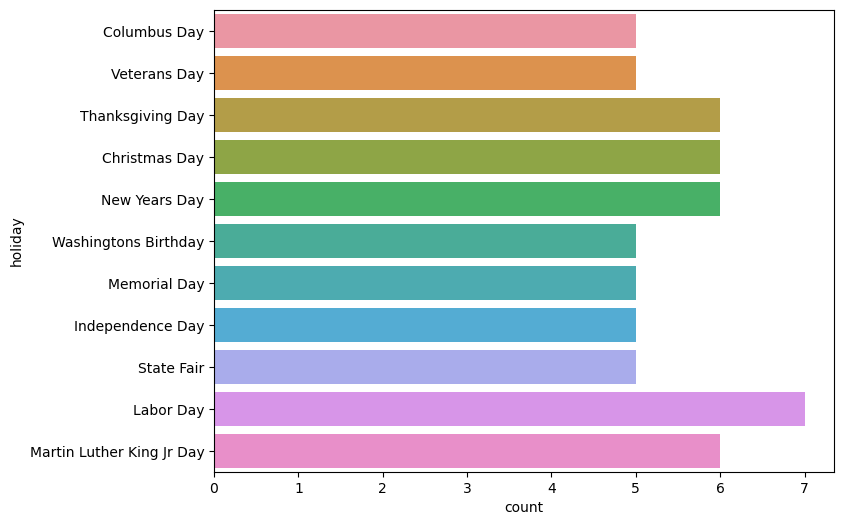

In [64]:
#Plotting frequency of each category in holiday column
plt.figure(figsize = (8,6))
sns.countplot(y='holiday', data = df)
plt.show()

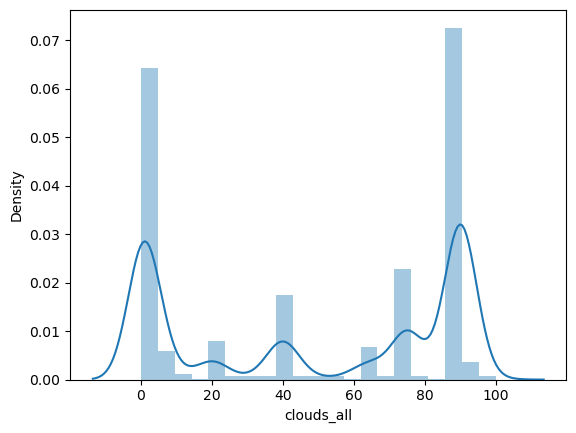

In [65]:
#clouds_all indicates the cloud coverage for the give day and hour
sns.distplot(df.clouds_all)
plt.show()

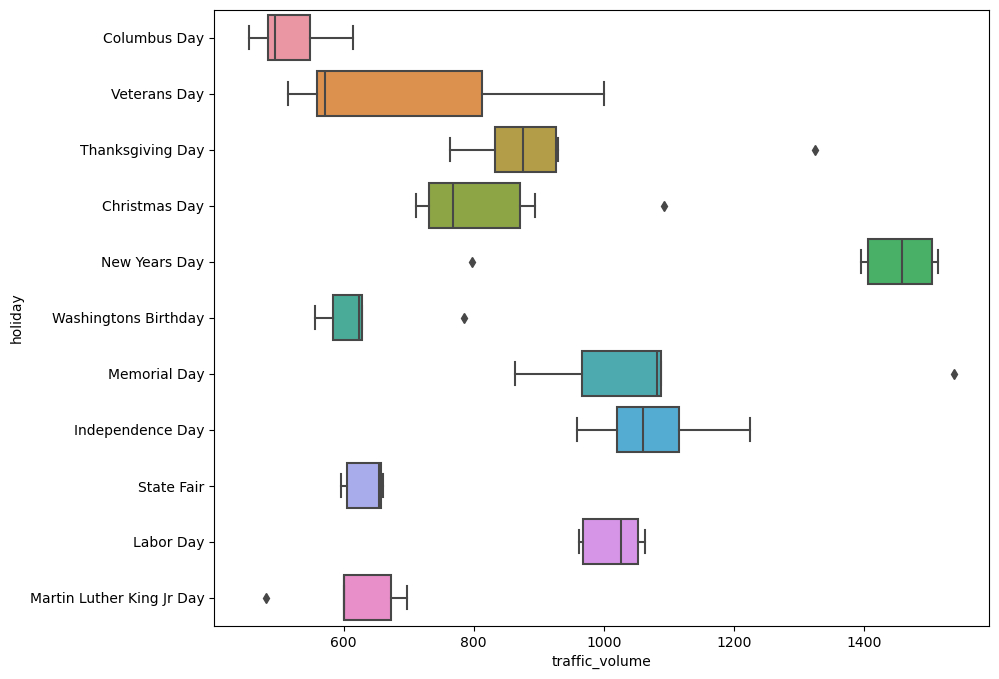

In [66]:
holidays = df.loc[df.holiday != 'None']
#Exploring traffic volume on holidays
plt.figure(figsize=(10,8))
sns.boxplot(y='holiday',x='traffic_volume', data = holidays)
plt.show()

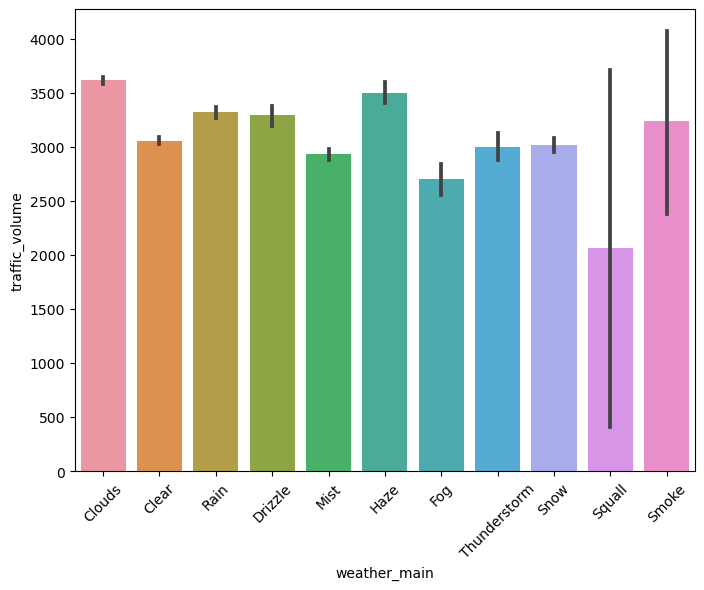

In [67]:
#Plotting weather_main over traffic volume
plt.figure(figsize=(8,6))
sns.barplot(x='weather_main', y = 'traffic_volume', data = df)
plt.xticks(rotation=45)

plt.show()

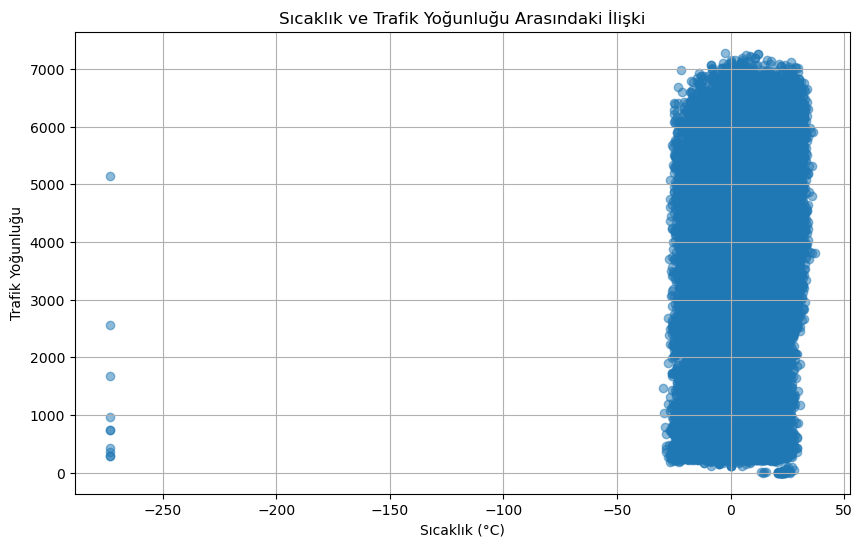

In [68]:
x = df['temp']  # Sıcaklık
y = df['traffic_volume']  # Trafik Yoğunluğu

# Scatter plot çizme
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)  # alpha, noktaların saydamlığını belirler
plt.title('Sıcaklık ve Trafik Yoğunluğu Arasındaki İlişki')
plt.xlabel('Sıcaklık (°C)')
plt.ylabel('Trafik Yoğunluğu')
plt.grid(True)
plt.show()

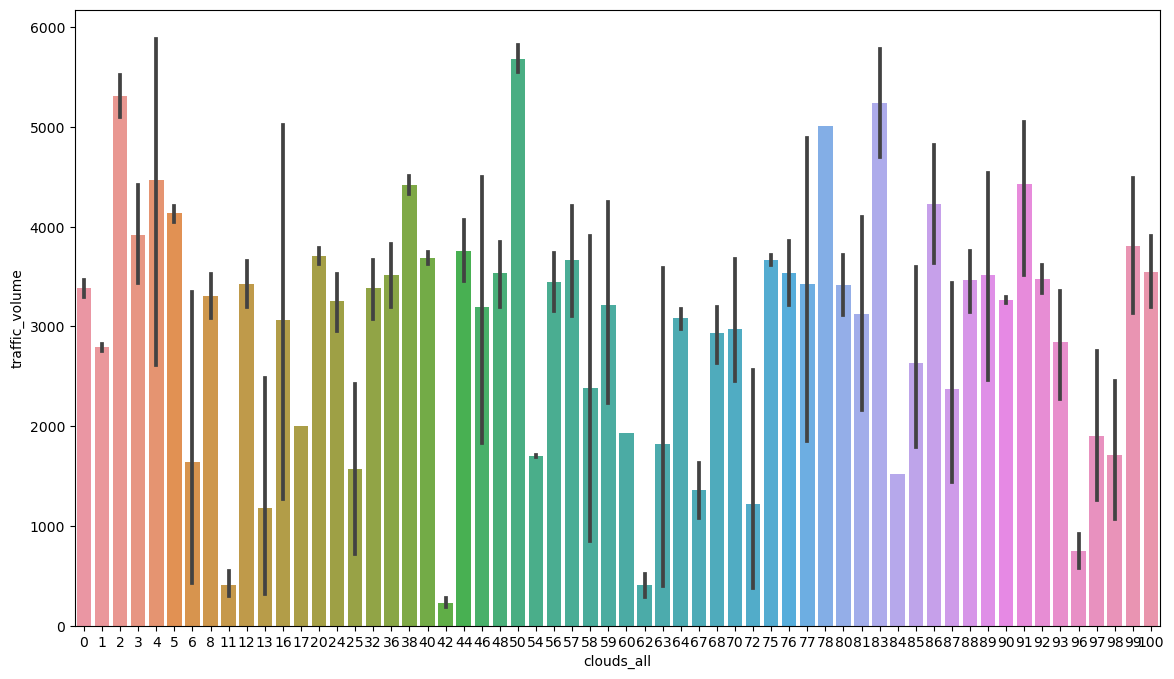

In [69]:
#Plotting traffic volume over clouds_all
plt.figure(figsize=(14,8))
sns.barplot(x='clouds_all', y = 'traffic_volume', data = df)
plt.show()

In [70]:
# df_date_traffic = df.groupby('date_time').aggregate({'traffic_volume':'mean'})
# plt.figure(figsize=(8,6))
# sns.lineplot(x = df_date_traffic.index, y = df_date_traffic.traffic_volume, data = df)
# plt.show()

In [71]:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Calculate lower and upper bounds for detecting outliers using the IQR (Interquartile Range) method.

    Parameters:
    -------
        dataframe (DataFrame): The DataFrame containing the data.
        col_name (str): The name of the column for which to calculate the outlier thresholds.
        q1 (float, optional): The lower quartile value (default is 0.25).
        q3 (float, optional): The upper quartile value (default is 0.75).

    Returns:
    ------
        float: The lower threshold for outliers.
        float: The upper threshold for outliers.
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(
        dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~(
        (dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def check_outlier(dataframe, col_names):
    low_limit, up_limit = outlier_thresholds(dataframe, col_names)

    if dataframe[(dataframe[col_names] < low_limit) | (dataframe[col_names] > up_limit)].any(axis=None):
        return True
    else:
        return False

def label_encoder(dataframe, binary_col):
    """
    Encodes binary categorical columns using Label Encoding.

    Parameters:
    -----------
        dataframe: DataFrame
            The DataFrame containing the categorical column to be encoded.
        binary_col: str
            The name of the binary categorical column to be encoded.

    Returns:
    --------
        dataframe: DataFrame
            The DataFrame with the specified binary column encoded using Label Encoding.
    """
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    """
    Applies one-hot encoding to categorical columns in the DataFrame.

    Parameters:
    -----------
        dataframe: DataFrame
            The DataFrame containing the categorical columns to be one-hot encoded.
        categorical_cols: list
            A list of column names that are categorical and need one-hot encoding.
        drop_first: bool, optional
            Whether to drop the first encoded category in each column. Default is False.

    Returns:
    --------
        dataframe: DataFrame
            The DataFrame with categorical columns one-hot encoded.
    """
    dataframe = pd.get_dummies(
        dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe






def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numeric variables with categorical appearances are also included in categorical variables.

    Parameters
    ------
        dataframe: DataFrame
                The DataFrame for which variable names are to be extracted.
        cat_th: int, optional
                Threshold for numeric but categorical variables.
        car_th: int, optional
                Threshold for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
                List of categorical variables.
        num_cols: list
                List of numerical variables.
        cat_but_car: list
                List of categorical variables that appear cardinal.

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        num_but_cat is included in cat_cols.
        The total of the three lists returned equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car



def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=45)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40,
                 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.xticks(rotation=45)
        plt.show(block=True)


Observations: 48204
Variables: 8
cat_cols: 2
num_cols: 5
cat_but_car: 1
num_but_cat: 0
                           holiday     Ratio
holiday                                     
Labor Day                        7  0.014522
Thanksgiving Day                 6  0.012447
Christmas Day                    6  0.012447
New Years Day                    6  0.012447
Martin Luther King Jr Day        6  0.012447
Columbus Day                     5  0.010373
Veterans Day                     5  0.010373
Washingtons Birthday             5  0.010373
Memorial Day                     5  0.010373
Independence Day                 5  0.010373
State Fair                       5  0.010373
##########################################


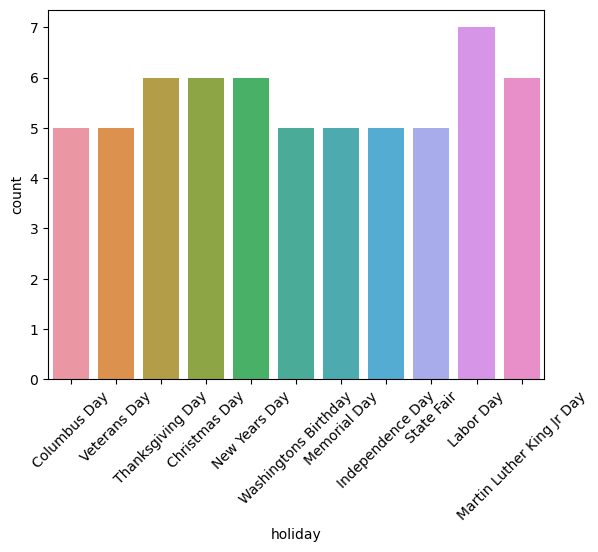

              weather_main      Ratio
weather_main                         
Clouds               15164  31.457970
Clear                13391  27.779852
Mist                  5950  12.343374
Rain                  5672  11.766658
Snow                  2876   5.966310
Drizzle               1821   3.777695
Haze                  1360   2.821343
Thunderstorm          1034   2.145050
Fog                    912   1.891959
Smoke                   20   0.041490
Squall                   4   0.008298
##########################################


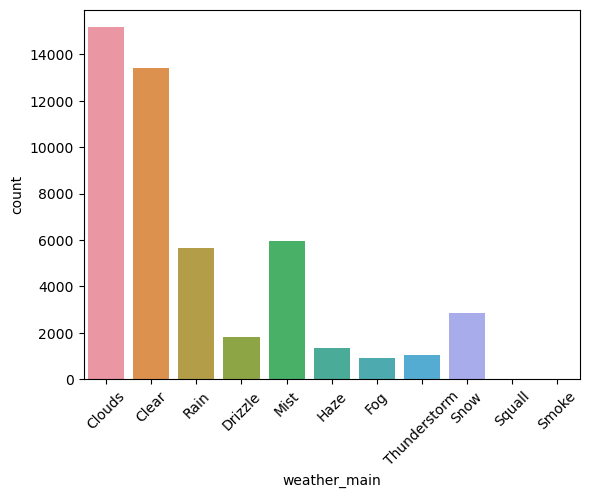

In [72]:
        
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=11, car_th=30)
        
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [73]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

count    48204.000000
mean         8.096721
std         12.766197
min        -76.235000
5%         -14.810000
10%         -9.197000
20%         -2.860000
30%          0.790000
40%          3.872000
50%          9.300000
60%         13.840000
70%         17.330000
80%         20.230000
90%         23.540000
95%         26.140000
99%         29.670000
max         36.920000
Name: temp, dtype: float64


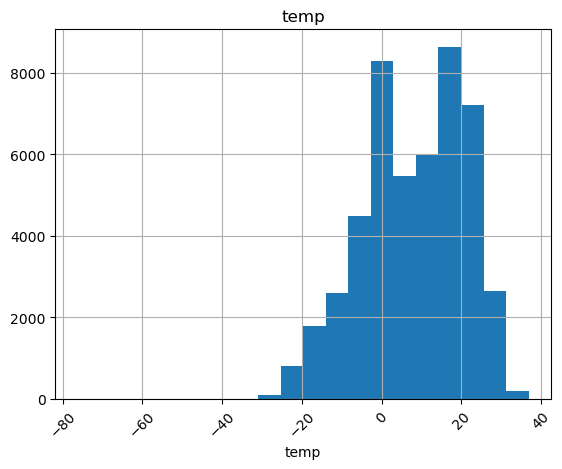

count    48204.000000
mean         0.039057
std          0.152387
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.300000
99%          0.750000
max          0.750000
Name: rain_1h, dtype: float64


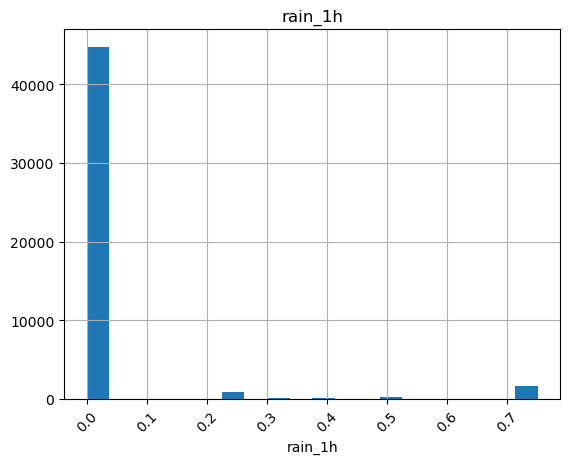

count    48204.0
mean         0.0
std          0.0
min          0.0
5%           0.0
10%          0.0
20%          0.0
30%          0.0
40%          0.0
50%          0.0
60%          0.0
70%          0.0
80%          0.0
90%          0.0
95%          0.0
99%          0.0
max          0.0
Name: snow_1h, dtype: float64


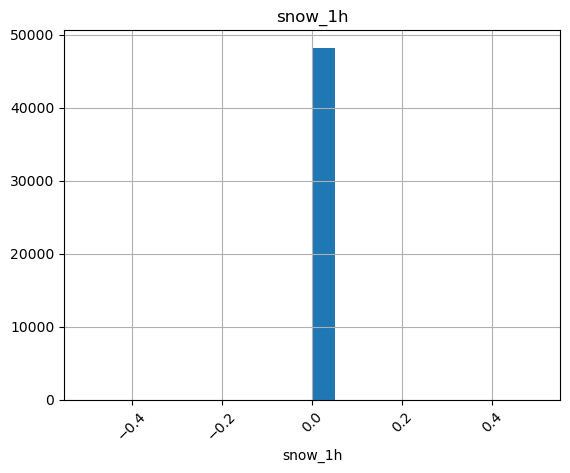

count    48204.000000
mean        49.362231
std         39.015750
min          0.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%         40.000000
50%         64.000000
60%         75.000000
70%         90.000000
80%         90.000000
90%         90.000000
95%         90.000000
99%         92.000000
max        100.000000
Name: clouds_all, dtype: float64


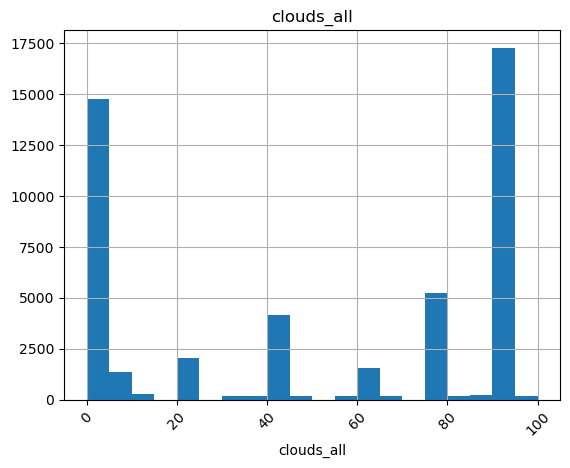

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
5%         339.000000
10%        425.000000
20%        860.000000
30%       1804.800000
40%       2741.000000
50%       3380.000000
60%       4259.000000
70%       4721.000000
80%       5180.000000
90%       5820.000000
95%       6197.000000
99%       6701.970000
max       7280.000000
Name: traffic_volume, dtype: float64


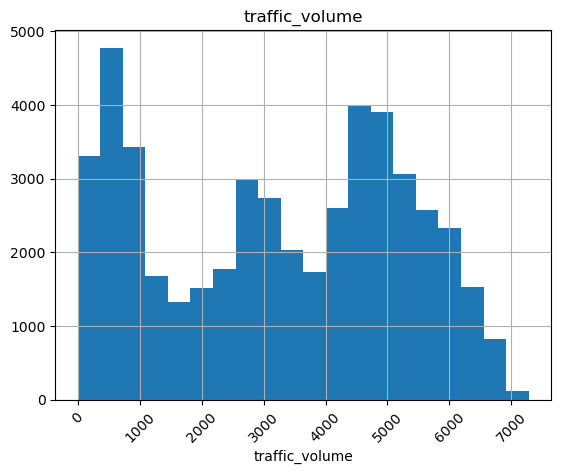

In [74]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [75]:
formal_holidays = {"New Year's Day": '01-01-2024', 'Martin Luther King Jr. Day': '15-01-2024', 
                   "Presidents' Day": '19-02-2024', 'Memorial Day': '27-05-2024', 
                   'Independence Day': '04-07-2024', 'Labor Day': '02-09-2024', 'Columbus Day': '14-10-2024', 
                   'Veterans Day': '11-11-2024', 'Thanksgiving Day': '28-11-2024', 'Christmas Day': '25-12-2024'}

formal_days_date = list(formal_holidays.values())
formal_days_date

['01-01-2024',
 '15-01-2024',
 '19-02-2024',
 '27-05-2024',
 '04-07-2024',
 '02-09-2024',
 '14-10-2024',
 '11-11-2024',
 '28-11-2024',
 '25-12-2024']

In [76]:
def generate_holiday_hours(holidays):
    """
    Tatil günleri için günün her saati için tarihleri oluşturan fonksiyon.

    Parametreler:
    - holidays: Tatil günlerinin listesi (format: dd-mm-yyyy).

    Returns:
    - holiday_hours: Tatil günleri için günün her saati için tarihlerin listesi (format: dd-mm-yyyy HH:MM:SS).
    """
    holiday_hours = []
    for holiday in holidays:
        for hour in range(24):
            # Tatil günü ve saati birleştirme
            holiday_datetime = datetime.strptime(holiday, '%d-%m-%Y') + timedelta(hours=hour)
            # Oluşturulan tarih ve saati listeye ekleme
            holiday_hours.append(holiday_datetime.strftime('%d-%m-%Y %H:%M:%S'))
    return holiday_hours




In [77]:
holidays_with_hours = generate_holiday_hours(formal_days_date)
len(holidays_with_hours)
holidays_with_hours = pd.to_datetime(holidays_with_hours, format='%d-%m-%Y %H:%M:%S')
holidays_with_hours

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00', '2024-01-01 02:00:00', '2024-01-01 03:00:00', '2024-01-01 04:00:00', '2024-01-01 05:00:00', '2024-01-01 06:00:00', '2024-01-01 07:00:00', '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               ...
               '2024-12-25 14:00:00', '2024-12-25 15:00:00', '2024-12-25 16:00:00', '2024-12-25 17:00:00', '2024-12-25 18:00:00', '2024-12-25 19:00:00', '2024-12-25 20:00:00', '2024-12-25 21:00:00', '2024-12-25 22:00:00', '2024-12-25 23:00:00'],
              dtype='datetime64[ns]', length=240, freq=None)

In [78]:
df.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
df_copy = df.copy()


In [79]:
df.shape

(40575, 8)

In [80]:
df["date_time"] = pd.to_datetime(df["date_time"])
df['holiday'] = df['date_time'].dt.strftime('%m-%d').isin(holidays_with_hours.strftime('%m-%d')).astype(int)


In [81]:
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['date_time'].dt.hour.apply(time_of_day)

In [82]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,time_of_day
0,0,15.13,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,morning
1,0,16.21,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,morning
2,0,16.43,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,morning
3,0,16.98,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026,afternoon
4,0,17.99,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918,afternoon


In [83]:
def create_date_features(df):
  df["month"] = df.date_time.dt.month
  df["day_of_month"] = df.date_time.dt.day
  df["day_of_year"] = df.date_time.dt.dayofyear
  df["day_of_week"] = df.date_time.dt.dayofweek
  df["year"] = df.date_time.dt.year
  df["is_weekend"] = df.date_time.dt.weekday // 4
  df["is_month_start"] = df.date_time.dt.is_month_start.astype(int)
  df["is_month_end"] = df.date_time.dt.is_month_end.astype(int)
  return df


In [84]:
df = create_date_features(df)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,time_of_day,month,day_of_month,day_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end
0,0,15.13,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,morning,10,2,276,1,2012,0,0,0
1,0,16.21,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,morning,10,2,276,1,2012,0,0,0
2,0,16.43,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,morning,10,2,276,1,2012,0,0,0
3,0,16.98,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026,afternoon,10,2,276,1,2012,0,0,0
4,0,17.99,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918,afternoon,10,2,276,1,2012,0,0,0


In [85]:
df.shape

(40575, 17)

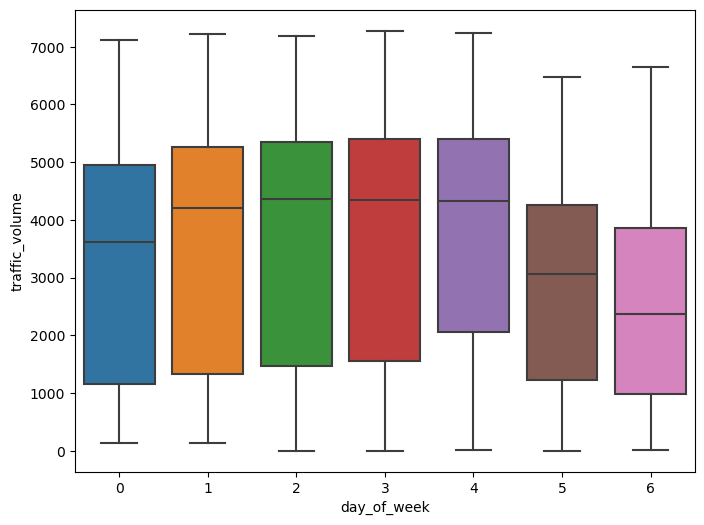

In [86]:
#Traffic volume plotted against weekday. Weekends show less traffic volume.
plt.figure(figsize=(8,6))
sns.boxplot(x='day_of_week', y='traffic_volume', data = df)
plt.show()

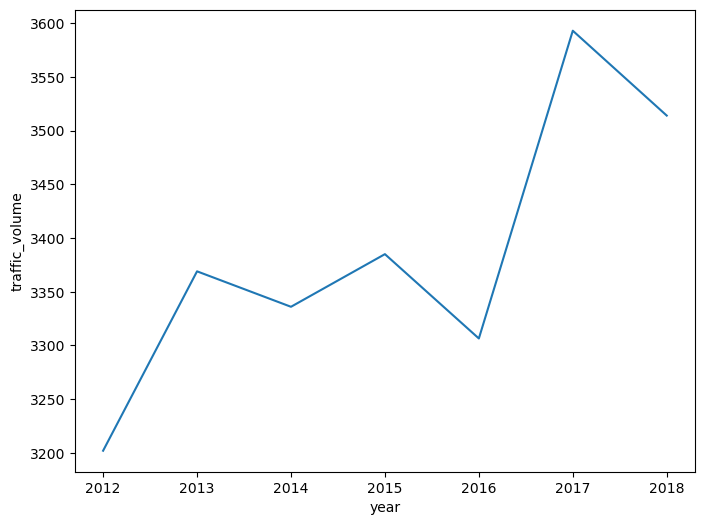

In [87]:
#aggreagating traffic volume over year and plotting 

df_date_traffic = df.groupby('year').aggregate({'traffic_volume':'median'})
plt.figure(figsize=(8,6))
sns.lineplot(x = df_date_traffic.index, y = df_date_traffic.traffic_volume, data = df_date_traffic)
plt.show()

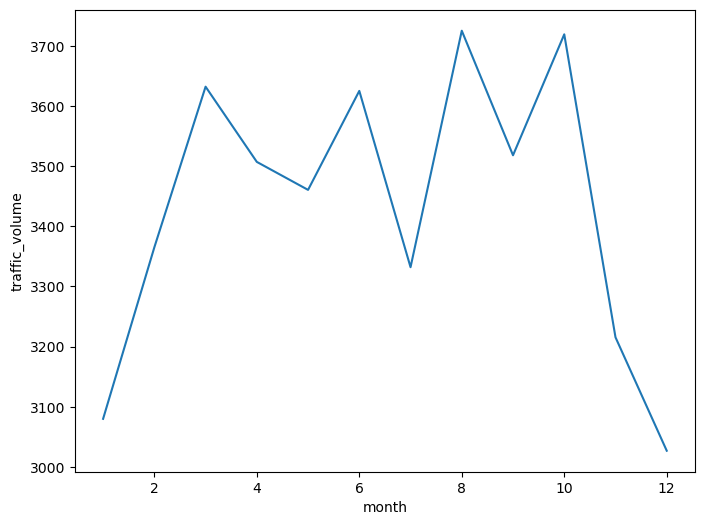

In [88]:
#aggreagating traffic volume over year and plotting 

df_date_traffic = df.groupby('month').aggregate({'traffic_volume':'median'})
plt.figure(figsize=(8,6))
sns.lineplot(x = df_date_traffic.index, y = df_date_traffic.traffic_volume, data = df_date_traffic)
plt.show()

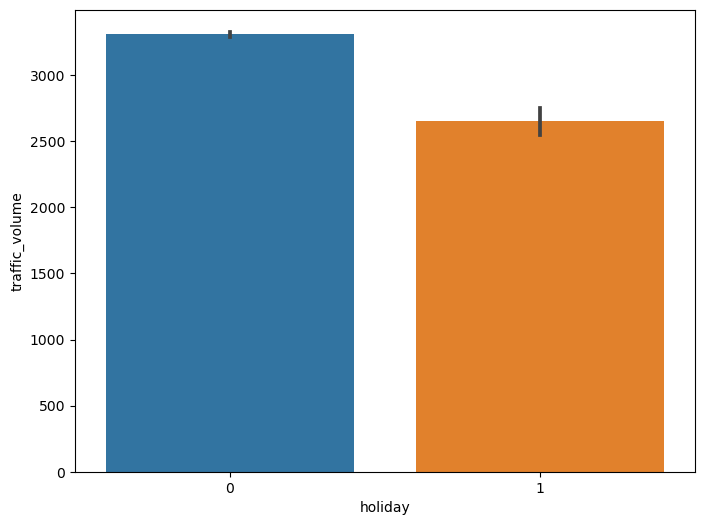

In [89]:
plt.figure(figsize=(8,6))
sns.barplot(x='holiday', y='traffic_volume', data = df)
plt.show()

In [90]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=11, car_th=30)


cat_cols

Observations: 40575
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 7


['weather_main',
 'time_of_day',
 'holiday',
 'snow_1h',
 'day_of_week',
 'year',
 'is_weekend',
 'is_month_start',
 'is_month_end']

In [91]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

[]

In [92]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [93]:
df.drop("date_time", axis=1, inplace=True)

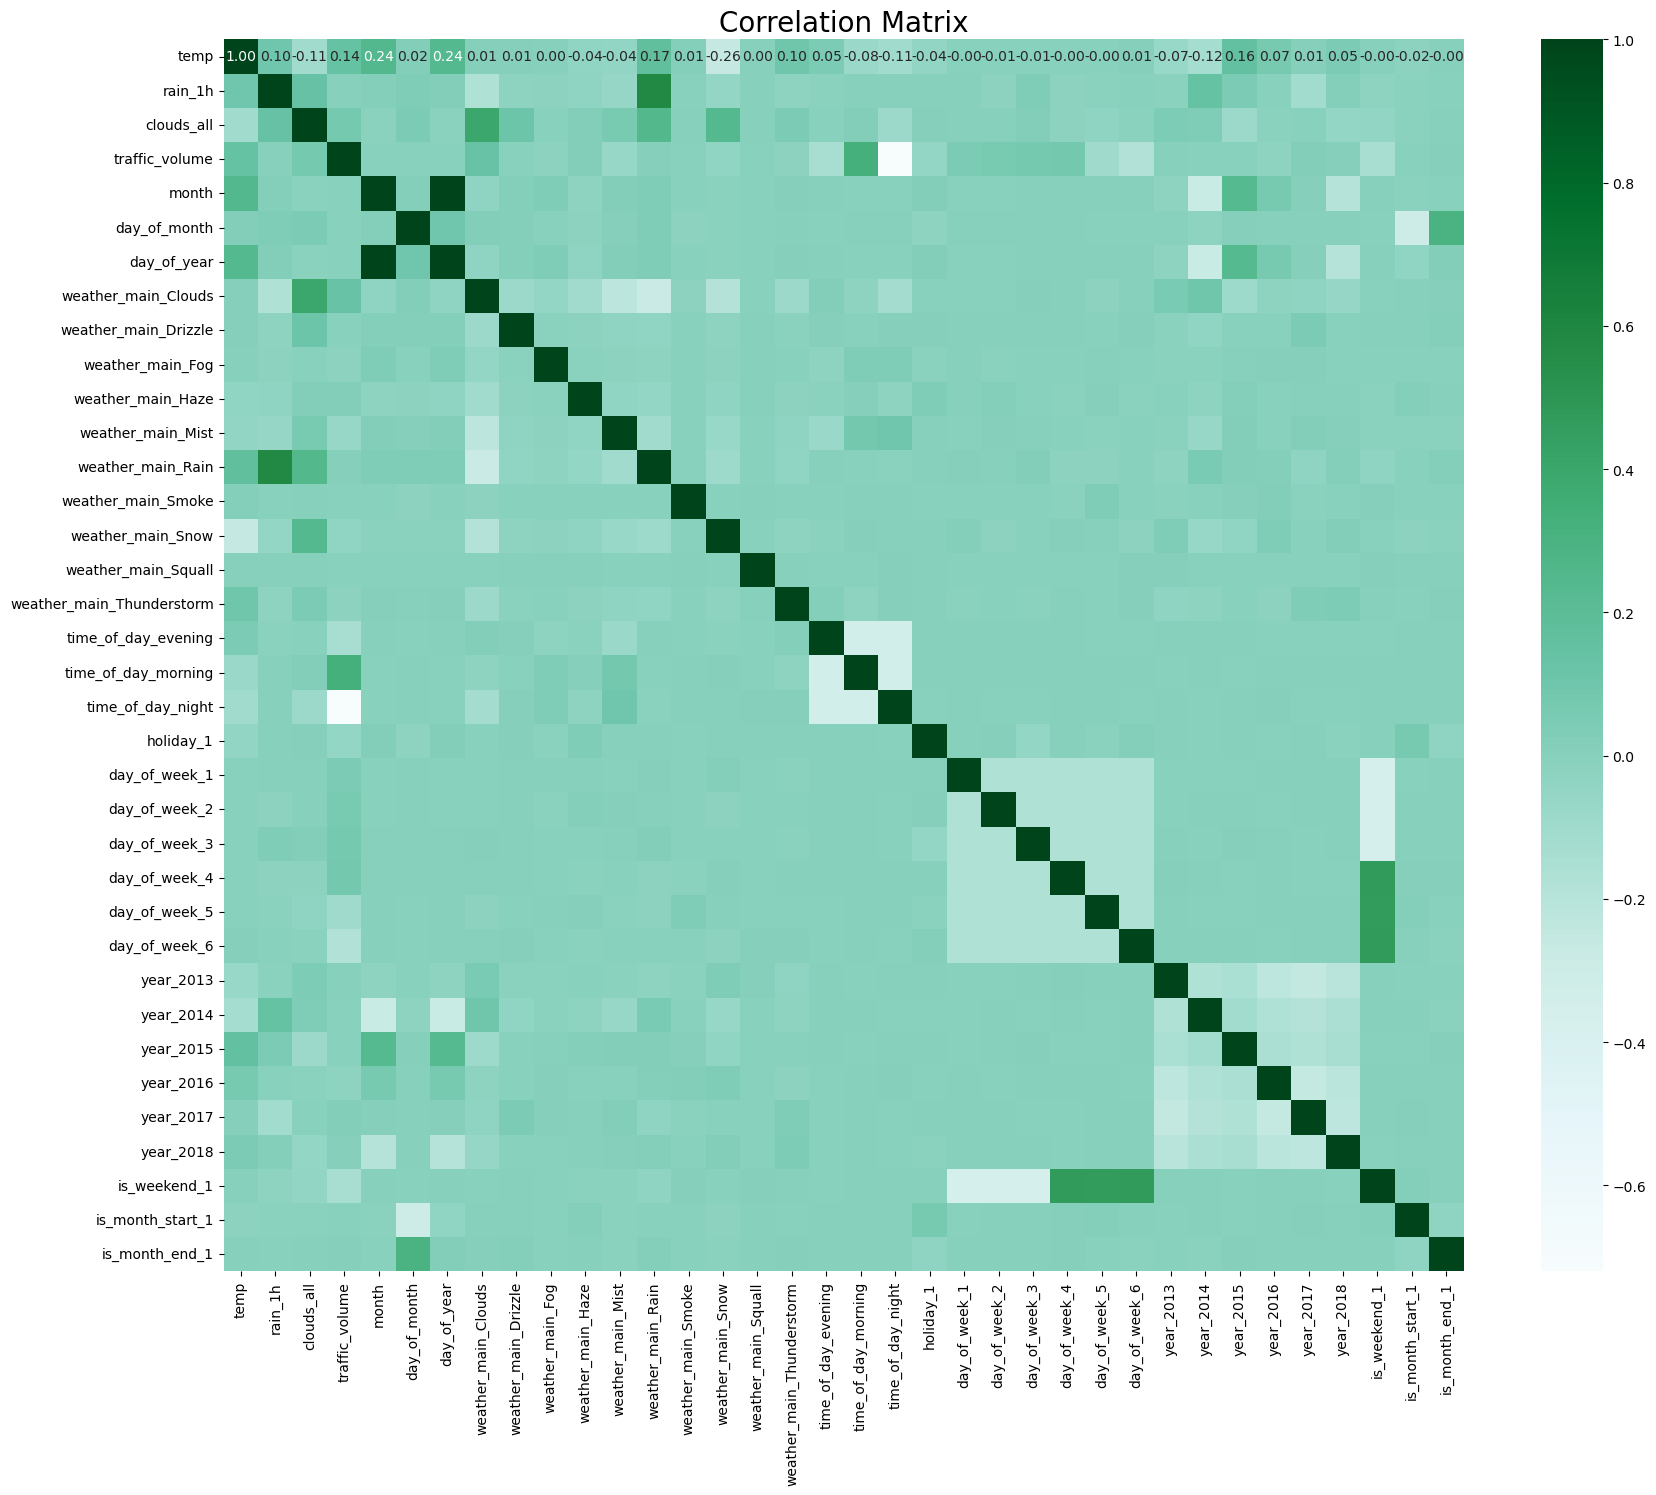

In [94]:
f, ax = plt.subplots(figsize=[20, 16])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="BuGn")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

In [95]:
df.corr()

,temp,rain_1h,clouds_all,traffic_volume,month,day_of_month,day_of_year,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,time_of_day_evening,time_of_day_morning,time_of_day_night,holiday_1,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_weekend_1,is_month_start_1,is_month_end_1
temp,1.000000,0.099597,-0.107420,0.140106,0.241391,0.023883,0.239152,0.005663,0.007903,0.002551,-0.035822,-0.044280,0.171428,0.013025,-0.260907,0.001100,0.102124,0.050847,-0.081641,-0.106425,-0.043089,-0.001184,-0.005984,-0.005184,-0.003423,-0.003923,0.006507,-0.074838,-0.122889,0.157919,0.067727,0.006125,0.051184,-0.000599,-0.019356,-0.000189
rain_1h,0.099597,1.000000,0.135142,0.000167,0.017015,0.031155,0.019153,-0.162586,-0.023915,-0.014882,-0.029258,-0.060336,0.577949,-0.004056,-0.051669,-0.001047,-0.022412,-0.008669,0.005296,-0.000822,-0.000018,0.004284,-0.017281,0.033634,-0.014670,-0.014379,-0.001694,-0.011949,0.140076,0.046759,-0.002974,-0.110299,0.012825,-0.021778,-0.009089,-0.003323
clouds_all,-0.107420,0.135142,1.000000,0.078370,-0.013179,0.046718,-0.008789,0.395954,0.106352,-0.005427,0.024767,0.064760,0.250046,0.002354,0.234136,0.003953,0.047890,-0.005575,0.019700,-0.087244,0.007584,0.001756,-0.000860,0.021701,-0.015591,-0.032146,-0.012103,0.042172,0.030737,-0.082682,-0.012152,-0.002816,-0.050890,-0.042341,-0.010413,0.002102
traffic_volume,0.140106,0.000167,0.078370,1.000000,-0.004517,-0.004250,-0.005160,0.126742,-0.007474,-0.020129,0.021477,-0.062902,0.011882,-0.007083,-0.035644,-0.007180,-0.015916,-0.141487,0.331882,-0.720108,-0.054103,0.049730,0.065376,0.074725,0.079652,-0.096161,-0.178080,0.004459,-0.003650,-0.005121,-0.023903,0.022643,0.007339,-0.137270,-0.006180,0.006031
month,0.241391,0.017015,-0.013179,-0.004517,1.000000,0.013624,0.996378,-0.032799,0.012605,0.027231,-0.027731,0.021885,0.036719,-0.003168,-0.008451,-0.002191,0.007472,0.002551,-0.003424,-0.002862,0.021304,-0.003280,-0.002565,0.004363,0.000330,0.003623,0.000431,-0.023060,-0.274014,0.230428,0.068447,0.006635,-0.190637,0.003097,-0.010528,-0.001984
day_of_month,0.023883,0.031155,0.046718,-0.004250,0.013624,1.000000,0.098259,0.023345,0.017950,-0.003133,-0.020732,0.008161,0.034523,-0.016398,-0.011990,-0.002081,0.001880,-0.003432,0.003514,0.002611,-0.025857,-0.000119,0.001888,0.004846,0.003677,-0.005930,-0.004416,-0.001311,-0.026928,0.010887,0.004794,0.003638,0.000221,-0.004697,-0.299970,0.306380
day_of_year,0.239152,0.019153,-0.008789,-0.005160,0.996378,0.098259,1.000000,-0.030572,0.013992,0.026866,-0.029057,0.022866,0.038704,-0.004598,-0.008675,-0.002405,0.007161,0.002228,-0.003101,-0.002598,0.019528,-0.003251,-0.002382,0.004750,0.000643,0.003099,0.000012,-0.024088,-0.275772,0.229365,0.071590,0.005902,-0.190689,0.002654,-0.035926,0.024061
weather_main_Clouds,0.005663,-0.162586,0.395954,0.126742,-0.032799,0.023345,-0.030572,1.000000,-0.087399,-0.054388,-0.106926,-0.220499,-0.281316,-0.014824,-0.188827,-0.003827,-0.081906,0.020008,-0.023219,-0.119881,-0.002987,-0.003169,-0.001438,0.006752,0.003409,-0.014695,0.002294,0.055140,0.101342,-0.094223,-0.023028,-0.029105,-0.060875,-0.006329,0.004883,0.006144
weather_main_Drizzle,0.007903,-0.023915,0.106352,-0.007474,0.012605,0.017950,0.013992,-0.087399,1.000000,-0.008000,-0.015728,-0.032434,-0.041379,-0.002180,-0.027775,-0.000563,-0.012048,0.007637,-0.002868,0.008987,0.006529,-0.000878,0.000846,-0.000993,0.000254,-0.007817,0.007687,-0.012946,-0.036545,-0.002018,-0.006404,0.050617,-0.007739,0.000099,0.002514,0.014419
weather_main_Fog,0.002551,-0.014882,-0.005427,-0.020129,0.027231,-0.003133,0.026866,-0.054388,-0.008000,1.000000,-0.009787,-0.020183,-0.025750,-0.001357,-0.017284,-0.000350,-0.007497,-0.027247,0.030238,0.035244,-0.009713,0.004796,-0.008770,-0.001722,-0.004103,0.001353,-0.002797,-0.0138

In [96]:
for column in df.columns:
    if df[column].dtype == bool:
        df[column] = df[column].astype(int)

In [97]:
df.head()

,temp,rain_1h,clouds_all,traffic_volume,month,day_of_month,day_of_year,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,time_of_day_evening,time_of_day_morning,time_of_day_night,holiday_1,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_weekend_1,is_month_start_1,is_month_end_1
0,15.13,0.0,40,5545,10,2,276,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16.21,0.0,75,4516,10,2,276,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16.43,0.0,90,4767,10,2,276,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16.98,0.0,90,5026,10,2,276,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.99,0.0,75,4918,10,2,276,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)
df.head()

,temp,rain_1h,clouds_all,traffic_volume,month,day_of_month,day_of_year,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,time_of_day_evening,time_of_day_morning,time_of_day_night,holiday_1,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,is_weekend_1,is_month_start_1,is_month_end_1
0,0.807432,0.0,0.40,0.761676,0.818182,0.033333,0.753425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.816977,0.0,0.75,0.620330,0.818182,0.033333,0.753425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.818921,0.0,0.90,0.654808,0.818182,0.033333,0.753425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.823782,0.0,0.90,0.690385,0.818182,0.033333,0.753425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.832707,0.0,0.75,0.675549,0.818182,0.033333,0.753425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Verilerin hazırlanması
# Veri setini numpy dizilerine dönüştürme
X = np.array(df.drop(columns=['traffic_volume']))
y = np.array(df['traffic_volume'])

In [100]:
# Verileri train ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Train setini ve etiketlerini numpy dizilerine dönüştürme
X_train = np.array(X_train)
y_train = np.array(y_train)

# Test setini ve etiketlerini numpy dizilerine dönüştürme
X_test = np.array(X_test)
y_test = np.array(y_test)

# Validation setini oluşturma
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=100, random_state=23)


In [101]:
# Veri şekillerini yeniden düzenle
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [105]:
# Modeli oluşturma
model = Sequential()

# İlk LSTM katmanı
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))

# İkinci LSTM katmanı
model.add(LSTM(64, return_sequences=True, activation='tanh'))

# Üçüncü LSTM katmanı
model.add(LSTM(32, return_sequences=True, activation='tanh'))

# Dördüncü LSTM katmanı
model.add(LSTM(16, activation='tanh'))

# Dropout katmanı (overfitting önlemek için)
model.add(Dropout(0.3))

# Yoğun (Dense) katman
model.add(Dense(1))

# Öğrenme oranı ve bozulma oranı (decay) ile Adam optimizasyonu
optimizer = Adam(learning_rate=0.01, decay=1e-5)

# Modeli derleme
model.compile(optimizer=optimizer, loss='mse')

# Modelin özetini görüntüleme
model.summary()

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), verbose=2)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 128)         │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,945 (581.82 KB)

 Trainable params: 148,945 (581.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
506/506 - 8s - 16ms/step - loss: 0.0225 - val_loss: 0.0149
Epoch 2/35
506/506 - 2s - 5ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 3/35
506/506 - 2s - 4ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 4/35
506/506 - 2s - 4ms/step - loss: 0.0154 - val_loss: 0.0137
Epoch 5/35
506/506 - 2s - 4ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 6/35
506/506 - 2s - 5ms/step - loss: 0.0150 - val_loss: 0.0138
Epoch 7/35
506/506 - 3s - 6ms/step - loss: 0.0149 - val_loss: 0.0135
Epoch 8/35
506/506 - 3s - 5ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 9/35
506/506 - 3s - 5ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 10/35
506/506 - 3s - 5ms/step - loss: 0.0146 - val_loss: 0.0135
Epoch 11/35
506/506 - 2s - 5ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 12/35
506/506 - 3s - 5ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 13/35
506/506 - 3s - 5ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 14/35
506/506 - 3s - 5ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 15/35
506/506 - 2s - 5

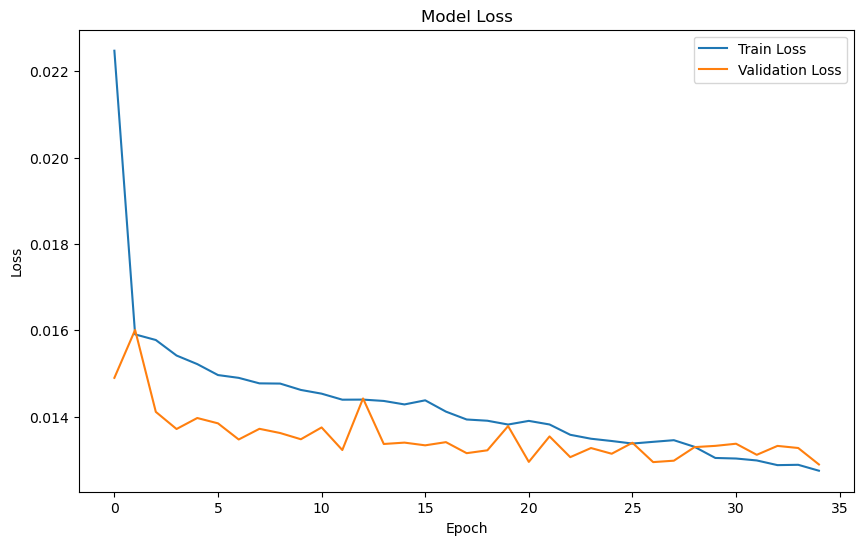

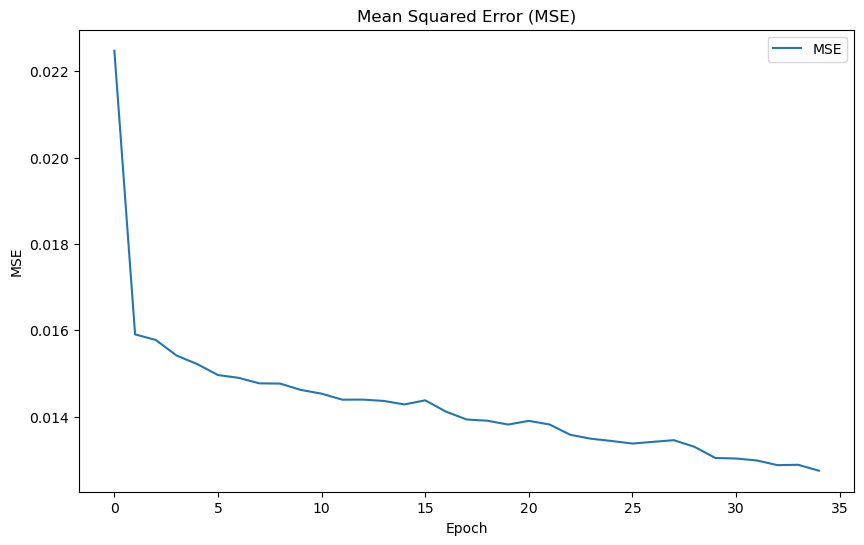

In [106]:

# Eğitim ve validation loss grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MSE grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='MSE')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


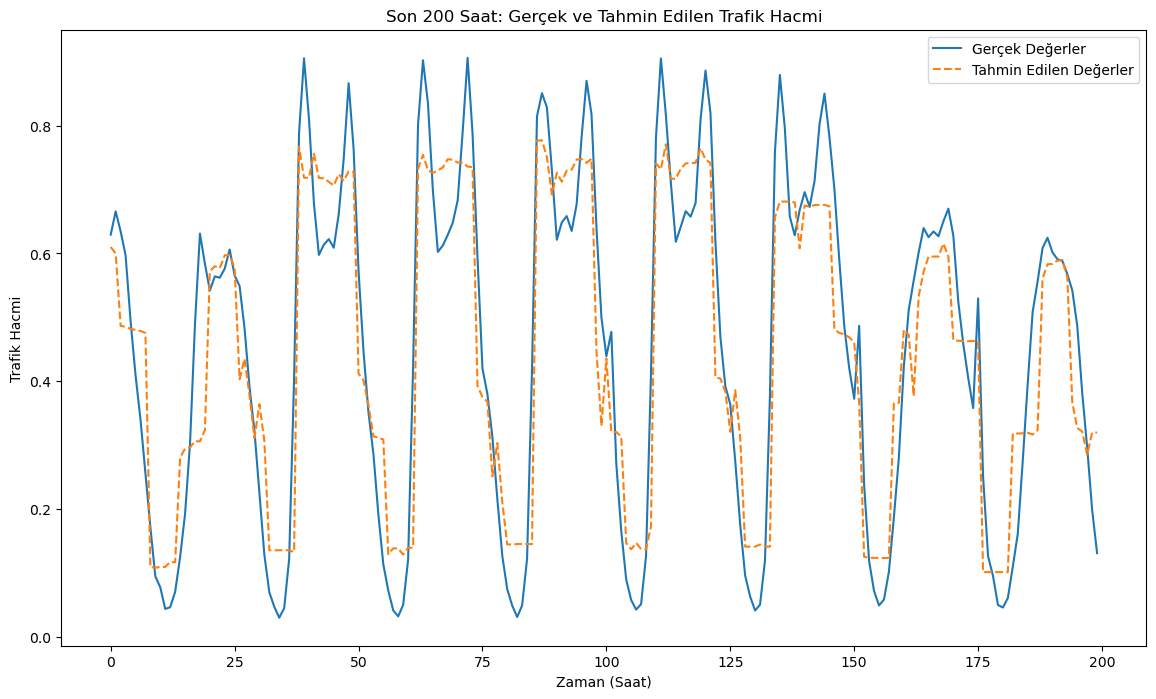

In [107]:
X_last_200_hours = df[-200:].drop(columns=['traffic_volume']).values.reshape(-1, 1, df.shape[1] - 1)
y_last_200_hours = df[-200:]['traffic_volume'].values

# Model ile tahmin yapma
y_pred = model.predict(X_last_200_hours)

# Gerçek ve tahmin edilen değerleri karşılaştırma ve plot oluşturma
plt.figure(figsize=(14, 8))
plt.plot(y_last_200_hours, label='Gerçek Değerler')
plt.plot(y_pred, label='Tahmin Edilen Değerler', linestyle='--')
plt.title('Son 200 Saat: Gerçek ve Tahmin Edilen Trafik Hacmi')
plt.xlabel('Zaman (Saat)')
plt.ylabel('Trafik Hacmi')
plt.legend()
plt.show()